Hunter Bennett | Strains Project | 20 April 2021

Notebook to examine data quality and identify poised enhancers from annotated set of merged peaks. PCA plots compiled in **Extended Data Figure 3**

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib_venn import venn3
import seaborn as sns

Set working directory

In [2]:
workingDirectory = '/home/h1bennet/strains_github/results/Figure2_H3K27Ac/' # user will need to set own wd
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


Define custom functions

In [3]:
def label_point(x, y, val, ax, fontsize=12, color='k', plot_points=False, pointsize=8, pointcolor='b'):
    '''This function makes it easier to overlay plotted points onto a matplotlib
    axes object. Allows for customization of fontsize and color and pointsize and
    point color.

        Accepts:
            x (int): list of x axis coordinates on plot
            y (int): list of y axis coordinates on plot
            val (str): list of text labels
            fontsize (int): size of fonts
            color (str): color of text
            plot_points (bool): whether to add points over text
            pointsize (int): size of points
            pointcolor (str): color of points
  
        Returns:
            None'''
 

    # import packages
    import matplotlib.pyplot as plt
    
    # plot over points
    if plot_points:
        for (xval, yval) in zip(x, y):
            ax.plot(xval, yval, markersize=pointsize, color=pointcolor)

    # plot over text
    for (xval, yval, text) in zip(x, y, val):
        ax.text(xval, yval, str(text), fontsize=fontsize)
        
def pca_rpkm_mat(rpkm, group_labels, n_pca=10, plot_size=8, legend=True):
    '''This function takes a pandas DF of rpkm values (genes x samples) with
    genes as the index and sample names as the column names and runs a simple
    PCA analysis.
    Accepts: 
    rpkm: gene x n_sample matrix of rpkm values
    group_labels: n_sample length array of group labels
    n_pca: number of principal components to analyze
    legend (bool): whether to plot legend
    Returns:
    tpm_pca_df: dataframe of principal components per each sample
    exp_var: array of explained variances for each PC
    '''
    
    # import packages
    import pandas as pd
    import numpy as np
    import seaborn as sns
    # Import packages for PCA analysis
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA # uses SVD
    
    # scale data
    tpm_std = StandardScaler().fit_transform(rpkm)
    # run PCA
    pca = PCA(n_components=n_pca)
    tpm_pca = pca.fit_transform(tpm_std.T)
    exp_var = pca.explained_variance_ratio_
    
    #create df for plotting
    tpm_pca_df = pd.DataFrame(tpm_pca,
                              columns=['PC'+str(i) for i in np.arange(1,tpm_pca.shape[1]+1)],
                              index=(group_labels))
    tpm_pca_df.index.rename('group', inplace=True)
    tpm_pca_df.reset_index(inplace=True)
    
    ax = sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
                hue='group', # palette=color_dict,
                height=plot_size, scatter_kws={'s': 150},
                legend=legend)
    ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
    
    # return weights of each gene  
    transcript_pc = pd.DataFrame(pca.components_.T,
                                 rpkm.index,
                                 columns=['PC'+str(i) for i in np.arange(1,tpm_pca.shape[1]+1)])    

    return tpm_pca_df, exp_var, transcript_pc

def read_annotated_peaks(path, filter_sex_unknown=True):
    '''This function imports an annotated homer peak file using
    pandas read_csv function. It also performes common preprocessing steps
    such as placing the peak IDs in the index and filtering so that
    only autosomal peaks are included. Also renames index to peakID.
       
       Accepts:
           path (str): path to expression file
           filter_sex_unkown (bool): filter unknown chromosomes
           and sex chromosomes - focus analysis on autosomal chr.
       
       Returns:
           df (pandas.Dataframe): genes by samples with annotation.
           mat (pandas.DataFrame): genes by samples without annotation.
       '''
    # import functions
    import pandas as pd

    df = pd.read_csv(path, sep='\t', index_col=0)

    # rename index
    df.index.rename('PeakID', inplace=True)
    # rename sample columns so they are shorter (can add .str.split('/').str[-1] to shorten even more
    df = df.rename(
        columns=dict(zip(df.iloc[:, 18:].columns.values,
                         pd.Series(df.iloc[:, 18:].columns.values).str.split(' Tag Count').str[0])))

    
    # filter unknown and sex chromosomes
    autosomes = ['chr1', 'chr2', 'chr3', 'chr4',
                 'chr5', 'chr6', 'chr7', 'chr8',
                 'chr9', 'chr10', 'chr11', 'chr12',
                 'chr13', 'chr14', 'chr15', 'chr16',
                 'chr17', 'chr18', 'chr19']

    df = df.loc[df.Chr.str.contains('|'.join(autosomes)), :]
      
    mat = df.iloc[:, 18:]
        
    return (df, mat)

In [4]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['savefig.dpi'] = 500

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8

# Descriptive analysis of data quality
1. Mean variance plot
2. Principal component analysis

Make folder for plots

In [5]:
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

Read in annotated peak files

In [6]:
# import annotation file
df, mat = read_annotated_peaks(
    'https://zenodo.org/record/7829622/files/variablewidth_peaks_h3k27ac_norm.txt') 

df.to_csv('./variablewidth_peaks_h3k27ac_norm.txt', sep='\t') # save for use in future scripts


Filter low tag peaks - using group based average tag filter

In [9]:
# use group based mat filter - have to set manually
print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
groups=[mat.columns.str.contains('AJ_Kupffer_Control'),
        mat.columns.str.contains('BALBcJ_Kupffer_Control'),
        mat.columns.str.contains('C57_Kupffer_Control')]
peaks = []
for group in groups:
    peaks.extend(mat.loc[mat.iloc[:, group].mean(1) > 5, :].index.tolist())
mat = mat.reindex(list(set(peaks)))
mat = mat.dropna(how='all')

22427 total peaks
filtering low tag count peaks


### Mean variance plot

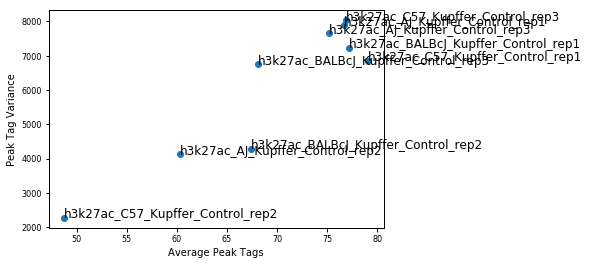

In [10]:
ax = plt.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat.columns,
            plt.gca())

plt.savefig('./figures/mean_variance_plot.png',
            bbox_inches='tight')

### Principal Component Analysis

Create sample ID data frame for ease of plotting. In our case we will extract the metadata from the smaple names themselves to create our sample info data frame

### Look at PCA plots for all the samples

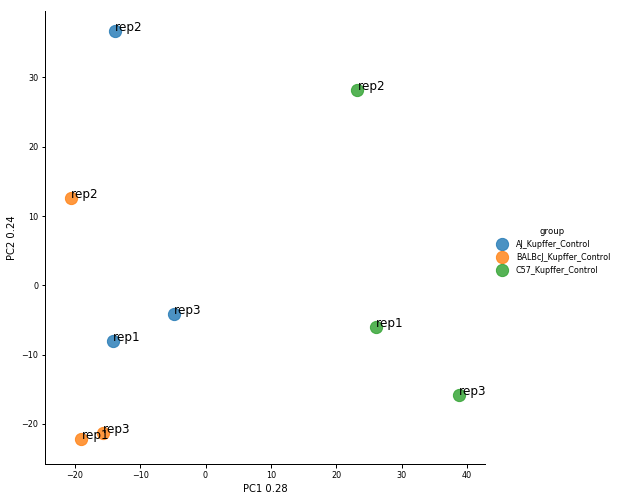

In [11]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=mat.columns.str[8:-5],
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            mat.columns.str[-4:],
            plt.gca())

# Assess degree of strain specific overlap of active enhancers

To do this we will create a list of peaks exceeding a certain tag thershold that we define as open (in this case 2^5 tags), and compare the degree to which these overlap amongst the strains.

We will do this with the atac-seq annotated peak set since we use this to call motifs later on.

In [12]:
# import annotation file (if not already done)
df, mat = read_annotated_peaks('../../data/idr_peaks_h3k27ac_norm.txt') # change to zenodo url

# df.to_csv('./f1_idr_peaks_h3k27ac_norm.txt', sep='\t') # save for use in future scripts

In [13]:
groups = ['AJ', 'BALBcJ', 'C57Bl6J']
columns = [mat.columns.str.contains('AJ_Kupffer_Control'),
           mat.columns.str.contains('BALBcJ_Kupffer_Control'),
           mat.columns.str.contains('C57_Kupffer_Control')]

avg_tags = {}

for group, col in zip(groups, columns):
    avg_tags[group] = mat.loc[:, col].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags)

In [14]:
thresh=32

peak_dict = {}
for col in avg_tags_df.columns:
    peak_dict[col] = avg_tags_df.index[avg_tags_df[col]>thresh].tolist()

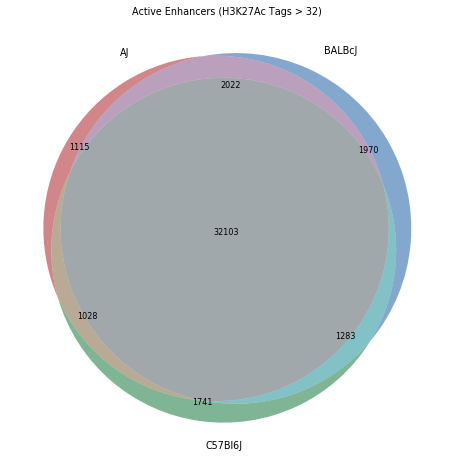

In [15]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(peak_dict['AJ']),
               set(peak_dict['BALBcJ']),
               set(peak_dict['C57Bl6J'])],
      set_colors=('#a50f15', '#08519c', '#006d2c'),
      set_labels=('AJ', 'BALBcJ', 'C57Bl6J'),
      alpha=0.5,
      ax=ax)
ax.set_title('Active Enhancers (H3K27Ac Tags > %d)' % thresh);


# Write 'active' enhancers out for analysis with HOMER
___
Should use the same threshold as venn diagram above

In [16]:
# make folder to write enhancers into
if not os.path.isdir('./active_enhancers/'):
    os.mkdir('./active_enhancers/')

Since these are based on ATAC-seq peaks we want to pull the original ATAC-seq merged peak file

In [17]:
atac_peaks = pd.read_csv('../../data/idr_peaks.txt', sep='\t', index_col=0) # change to zenodo

atac_peaks.to_csv('./idr_peaks.txt', sep='\t')

In [18]:
df_distal = df.loc[np.abs(df['Distance to TSS']) > 3*10**3, :]

In [19]:
new_start = []
new_end = []
for index, row in atac_peaks.iterrows():
    center = row.start + int(np.floor((row.end - row.start)/2))
    new_start.append(center - 100)
    new_end.append(center + 100)
    
atac_peaks_200bp = atac_peaks.iloc[:, :4].copy(deep=True)
atac_peaks_200bp['start'] = new_start
atac_peaks_200bp['end'] = new_end
atac_peaks_200bp.index.rename('PeakID', inplace=True)

# select distal peaks
atac_peaks_200bp_distal = atac_peaks_200bp.reindex(df_distal.index).dropna(how='all')

In [20]:
convert_dict = {'start': int,
                'end': int}

In [21]:
for col in avg_tags_df.columns:
    tmp = atac_peaks_200bp.reindex(avg_tags_df.index[avg_tags_df[col]>thresh].tolist())
    tmp = tmp.dropna(how='all').iloc[:, :5]
    # convert start and end positions back to integers
    tmp = tmp.astype(convert_dict)
    # filter unknown chromosomes
    tmp = tmp.loc[~tmp.chr.str.contains('random'), :]
    tmp.to_csv('./active_enhancers/'+col+'_active_enhancer_peaks.txt', sep='\t')
    
    tmp = atac_peaks_200bp_distal.reindex(avg_tags_df.index[avg_tags_df[col]>thresh].tolist())
    tmp = tmp.dropna(how='all').iloc[:, :5]
    # convert start and end positions back to integers
    tmp = tmp.astype(convert_dict)
    # filter unknown chromosomes
    tmp = tmp.loc[~tmp.chr.str.contains('random'), :]
    tmp.to_csv('./active_enhancers/'+col+'_active_distal_enhancer_peaks.txt', sep='\t')

### Write shared enhancers

In [22]:
shared = set(peak_dict['AJ']).intersection(peak_dict['BALBcJ']).intersection(peak_dict['C57Bl6J'])
tmp = atac_peaks_200bp.reindex(shared)
tmp = tmp.dropna(how='all').iloc[:, :5]
tmp = tmp.astype(convert_dict)
tmp.to_csv('./active_enhancers/shared_active_enhancer_peaks.txt', sep='\t')

tmp = atac_peaks_200bp_distal.reindex(shared)
tmp = tmp.dropna(how='all').iloc[:, :5]
tmp = tmp.astype(convert_dict)
tmp.to_csv('./active_enhancers/shared_active_distal_enhancer_peaks.txt', sep='\t')